In [1]:
!pip install pyspark

     ---------------------------------------- 0.0/317.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/317.0 MB ? eta -:--:--
     -------------------------------------- 0.0/317.0 MB 217.9 kB/s eta 0:24:15
     -------------------------------------- 0.1/317.0 MB 416.7 kB/s eta 0:12:41
     ---------------------------------------- 0.3/317.0 MB 1.1 MB/s eta 0:04:43
     ---------------------------------------- 0.5/317.0 MB 2.0 MB/s eta 0:02:41
     ---------------------------------------- 0.8/317.0 MB 2.6 MB/s eta 0:02:04
     ---------------------------------------- 1.0/317.0 MB 3.0 MB/s eta 0:01:46
     ---------------------------------------- 1.4/317.0 MB 3.5 MB/s eta 0:01:30
     ---------------------------------------- 1.5/317.0 MB 3.4 MB/s eta 0:01:32
     ---------------------------------------- 1.8/317.0 MB 3.9 MB/s eta 0:01:22
     ---------------------------------------- 2.1/317.0 MB 4.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.

import os
for dirname, _, filenames in os.walk('C:/Users/Legion/Downloads/bank.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ml-bank').getOrCreate()
sdf = spark.read.csv('C:/Users/Legion/Downloads/bank.csv', header = True, inferSchema = True)
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [5]:
import pandas as pd

pd.DataFrame(sdf.take(5), columns=sdf.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [6]:
sdf.toPandas().groupby(['deposit']).size()

deposit
no     5873
yes    5289
dtype: int64

In [7]:
numeric_features = [t[0] for t in sdf.dtypes if t[1] == 'int']
sdf.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [ ]:
#Correlations between independent variables

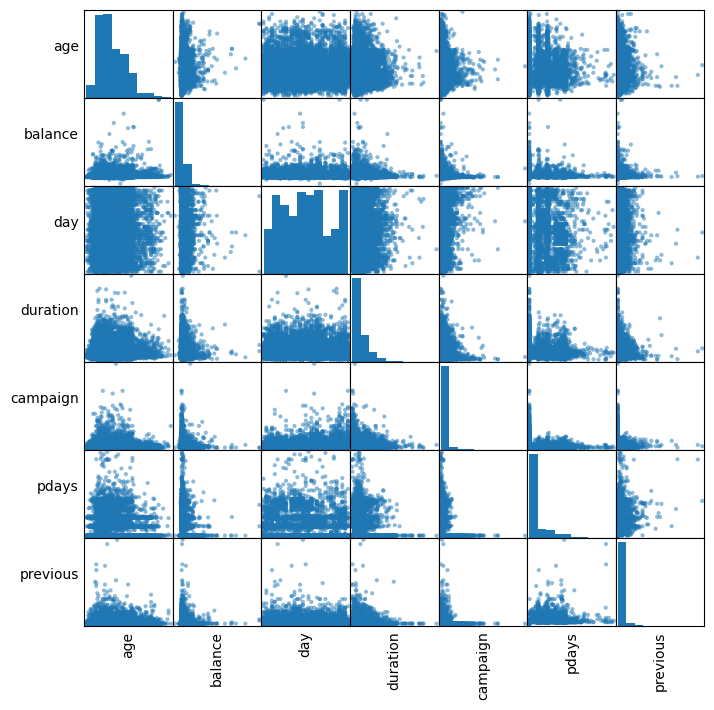

In [8]:
numeric_data = sdf.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [9]:
sdf = sdf.select(
    'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 
    'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit'
)
cols = sdf.columns
sdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [12]:
pip install --upgrade pyspark


Note: you may need to restart the kernel to use updated packages.


In [14]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []
categoricalColumns = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'
]

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(
        inputCols=[stringIndexer.getOutputCol()], 
        outputCols=[categoricalCol + "classVec"]
    )
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
#Pipeline

In [15]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(sdf)
sdf = pipelineModel.transform(sdf)
selectedCols = ['label', 'features'] + cols
sdf = sdf.select(selectedCols)
sdf.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [16]:
pdf = pd.DataFrame(sdf.take(5), columns=sdf.columns)
pdf.iloc[:,0:2] 

,label,features
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
len(pdf.features[0])

30

In [ ]:
#Split dataset into train and test set

In [18]:
train, test = sdf.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [ ]:
#Logistic Regression Model

In [19]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

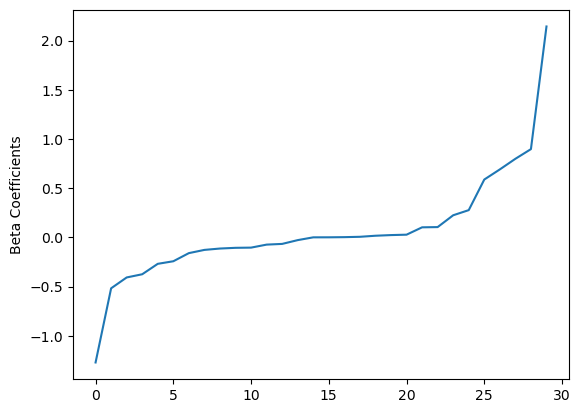

In [20]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

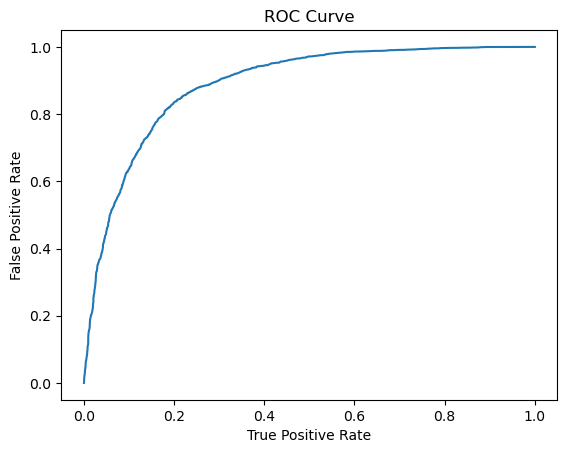

Training set areaUnderROC: 0.8877385690600346


In [21]:
trainingSummary = lrModel.summary
lrROC = trainingSummary.roc.toPandas()

plt.plot(lrROC['FPR'],lrROC['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
#Precision and recall

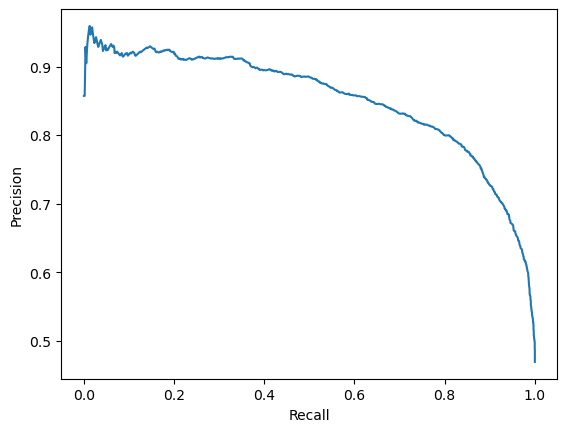

In [22]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [23]:
lrPreds = lrModel.transform(test)
lrPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93084854518128...|       0.0|[0.87334331124860...|
| 49|management|  0.0|[1.92783695472097...|       0.0|[0.87300981013433...|
| 52|management|  0.0|[-0.7737627890181...|       1.0|[0.31566570209267...|
| 53|management|  0.0|[0.94708137344074...|       0.0|[0.72052784002179...|
| 58|management|  0.0|[2.44657764692457...|       0.0|[0.92031082026376...|
| 32|management|  0.0|[1.28386077546037...|       0.0|[0.78310624913886...|
| 57|management|  0.0|[1.05745870556531...|       0.0|[0.74220460119091...|
| 52|management|  0.0|[3.25200815517462...|       0.0|[0.96274520587479...|
| 46|management|  0.0|[2.24978402804239...|       0.0|[0.90463190417562...|
| 31|management|  0.0|[1.47121751117284...|       0.0|[0.81324237120150...|
+---+-------

In [24]:
lrPreds.show()

+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+-------+--------------------+--------------------+----------+
|label|            features|age|       job|marital|education|default|balance|housing|loan|  contact|duration|campaign|pdays|previous|poutcome|deposit|       rawPrediction|         probability|prediction|
+-----+--------------------+---+----------+-------+---------+-------+-------+-------+----+---------+--------+--------+-----+--------+--------+-------+--------------------+--------------------+----------+
|  0.0|(30,[0,11,13,16,1...| 33|management|married|secondary|     no|    333|     no|  no| cellular|      80|       6|   -1|       0| unknown|     no|[1.93084854518128...|[0.87334331124860...|       0.0|
|  0.0|(30,[0,11,13,16,1...| 49|management|married|secondary|     no|   1601|     no|  no| cellular|      47|       5|   -1|       0| unknown|     no|[1.92783695472097...|[0.8730098101

In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lrEval = BinaryClassificationEvaluator()
print('Test Area Under ROC', lrEval.evaluate(lrPreds))

Test Area Under ROC 0.885643189559481


In [ ]:
#Decision Tree Classifier

In [30]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
dtPreds = dtModel.transform(test)
dtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [31]:
dtEval = BinaryClassificationEvaluator()
dtROC = dtEval.evaluate(dtPreds, {dtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(dtROC))

Test Area Under ROC: 0.7808118726917547


In [ ]:
#Random Forest Classifier

In [32]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
rfPreds = rfModel.transform(test)
rfPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[14.3078111636534...|       0.0|[0.71539055818267...|
| 49|management|  0.0|[14.1651346552377...|       0.0|[0.70825673276188...|
| 52|management|  0.0|[7.01727468738297...|       1.0|[0.35086373436914...|
| 53|management|  0.0|[12.1719504107229...|       0.0|[0.60859752053614...|
| 58|management|  0.0|[15.0325746048470...|       0.0|[0.75162873024235...|
| 32|management|  0.0|[13.9330660425079...|       0.0|[0.69665330212539...|
| 57|management|  0.0|[13.5152528220864...|       0.0|[0.67576264110432...|
| 52|management|  0.0|[16.7587737811564...|       0.0|[0.83793868905782...|
| 46|management|  0.0|[16.4956489404901...|       0.0|[0.82478244702450...|
| 31|management|  0.0|[14.7784857396774...|       0.0|[0.73892428698387...|
+---+-------

In [33]:
rfEval = BinaryClassificationEvaluator()
rfROC = rfEval.evaluate(rfPreds, {rfEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(rfROC))

Test Area Under ROC: 0.8800962617041411


In [ ]:
#Gradient-Boosted Tree Classifier

In [34]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
gbtPreds = gbtModel.transform(test)
gbtPreds.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[0.94992370947246...|       0.0|[0.86987425549896...|
| 49|management|  0.0|[1.28281748604659...|       0.0|[0.92861688965145...|
| 52|management|  0.0|[-0.5021429054421...|       1.0|[0.26809961471379...|
| 53|management|  0.0|[0.09646513340517...|       0.0|[0.54808351175538...|
| 58|management|  0.0|[1.05831377292163...|       0.0|[0.89250881497055...|
| 32|management|  0.0|[0.57268875896254...|       0.0|[0.75866558918304...|
| 57|management|  0.0|[0.34932946844840...|       0.0|[0.66789037418062...|
| 52|management|  0.0|[1.33264456943866...|       0.0|[0.93494709840561...|
| 46|management|  0.0|[1.28262818068783...|       0.0|[0.92859178839697...|
| 31|management|  0.0|[1.16094954405484...|       0.0|[0.91067454521219...|
+---+-------

In [35]:
gbtEval = BinaryClassificationEvaluator()
gbtROC = gbtEval.evaluate(gbtPreds, {gbtEval.metricName: "areaUnderROC"})
print("Test Area Under ROC: " + str(gbtROC))

Test Area Under ROC: 0.8935091626908479


In [36]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [37]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=gbtEval, numFolds=5)

# Run cross validations.  
# This can take some minutes since it is training over 20 trees!
cvModel = cv.fit(train)
cvPreds = cvModel.transform(test)
gbtEval.evaluate(cvPreds)

0.8954659543871663

In [39]:
lrPreds.select("age", "job", "marital", "education", "default", "balance", "housing", "loan", "contact", "duration", "campaign", "pdays", "previous", "poutcome", "deposit", "prediction").toPandas().to_csv('C:/Users/Legion/Downloads/lr_preds.csv', index=False)
